# 1. Imports

In [128]:
import numpy as np
import pandas as pd
import regex as re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from sklearn.linear_model import LinearRegression

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


# 2. Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read excel
polarization_data = pd.read_excel('/content/drive/MyDrive/final_results_comparison.xlsx',  index_col=0)
polarization_data

,id_new,split_speeches,BERT,GPT,mismatch
0,20_1_1066957_1,Sehr geehrter Herr Alterspräsident! So muss ic...,0,0,False
1,20_1_1066959_1,Nicht lange; da haben Sie schon recht. – Liebe...,0,0,False
2,20_1_1066959_2,Sie ist nicht in Stein gemeißelt – das wissen ...,0,0,False
3,20_1_1066959_3,Wir begrüßen auch ausdrücklich die Initiative ...,0,0,False
4,20_1_1066959_4,"Wir plädieren allerdings auch dafür, dass wir ...",0,0,False
...,...,...,...,...,...
150657,20_187_1075926_1,Sehr geehrte Frau Präsidentin! Kolleginnen und...,1,1,False
150658,20_187_1075926_2,Doch es ist etwas diffiziler und etwas differe...,0,0,False
150659,20_187_1075926_3,"Viele von ihnen haben Dinge erlebt, die wir un...",0,0,False
150660,20_187_1075926_4,Jeder Mensch hat ein Recht auf Schutz und auf ...,1,1,False


In [4]:
# read csv
features = pd.read_csv('/content/drive/MyDrive/content_df_features.csv', index_col=0)
features

,id,electoral_term,session,first_name,document_url,last_name,faction_id,position_short,position_long,politician_id,...,speech_content,date,faction,year,speech_length,age,gender,tenure,sentiment_score_1,sentiment_score_2
0,0,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,köhler,5,Presidium of Parliament,präsident,11001150,...,Meine Damen und Herren! Ich eröffne die 2. Sit...,1949-09-11,CDU/CSU,1949,546,57.0,männlich,0.000000,0.000000,0.047619
1,1,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,arnold,-1,Guest,präsident des bundesrats,-1,...,"Der Bundesrat ist versammelt, Herr Präsident.",1949-09-11,NaN,1949,45,NaN,NaN,0.000000,0.000000,0.000000
2,2,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,köhler,5,Presidium of Parliament,präsident,11001150,...,Ich danke für diese Erklärung. Ich stelle dami...,1949-09-11,CDU/CSU,1949,895,57.0,männlich,0.000000,0.133946,0.181818
3,3,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,heuss,-1,Guest,bundespräsident,-1,...,"Ja, ich habe den Wunsch.",1949-09-11,NaN,1949,24,NaN,NaN,0.000000,0.000000,1.000000
4,4,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,köhler,5,Presidium of Parliament,präsident,11001150,...,Ich erteile dem Herrn Bundespräsidenten das Wort.,1949-09-11,CDU/CSU,1949,49,57.0,männlich,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966041,1075922,20,187,thomas,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,seitz,0,Member of Parliament,NaN,11004891,...,Sehr geehrte Frau Präsidentin! Meine Damen und...,2024-09-25,AfD,2024,1799,57.0,männlich,6.594521,0.112649,0.030534
966042,1075923,20,187,petra,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,pau,7,Presidium of Parliament,Vizepräsidentin,11003206,...,Herr Abgeordneter.,2024-09-25,DIE LINKE.,2024,18,61.0,weiblich,25.887671,0.000000,0.000000
966043,1075924,20,187,thomas,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,seitz,18,Member of Parliament,NaN,11004891,...,Vielen Dank.,2024-09-25,Fraktionslos,2024,12,57.0,männlich,6.594521,0.000000,0.500000
966044,1075925,20,187,petra,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,pau,7,Presidium of Parliament,Vizepräsidentin,11003206,...,Für die SPD-Fraktion hat die Kollegin Angelika...,2024-09-25,DIE LINKE.,2024,65,61.0,weiblich,25.887671,0.000000,0.000000


# 3. Data Preparation

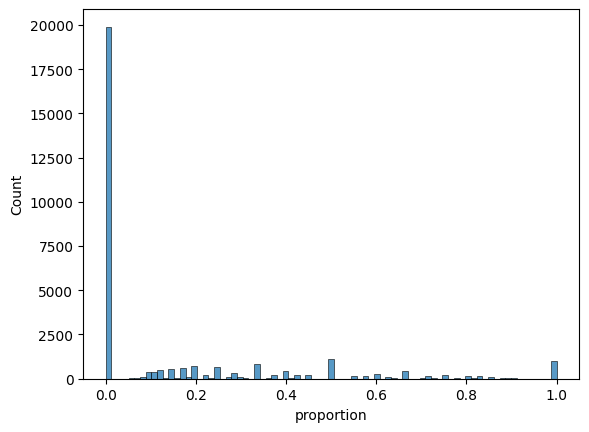

In [5]:
# remove last part of unique id
polarization_data["speech_id"] = polarization_data["id_new"].str.rsplit("_").str[2]
polarization_data["polarizing_amount"] = (polarization_data["BERT"]==1)& (polarization_data["GPT"]==1)
polarization_data

# group by speech_id, count polarizing speeches
polarization_data_grouped = polarization_data.groupby("speech_id").agg({"polarizing_amount":"sum", "id_new":"count"}).reset_index()
polarization_data_grouped['proportion'] = polarization_data_grouped['polarizing_amount']/polarization_data_grouped['id_new']
polarization_data_grouped

# show distibution of polarizing speeches
sns.histplot(polarization_data_grouped['proportion'])
plt.show()

In [6]:
# show proportion of polarizing
polarization_data_grouped[polarization_data_grouped['proportion']>=0.5].shape[0]/polarization_data_grouped.shape[0]

0.13704634822407014

In [7]:
polarization_data_grouped['polarizing'] = (polarization_data_grouped['proportion'] >= 0.5).astype(int)


In [8]:
# convert speech_id to int
polarization_data_grouped['speech_id'] = polarization_data_grouped['speech_id'].astype(int)

# merge with features
features_with_polarization = features.merge(polarization_data_grouped[['speech_id', 'polarizing']], left_on='id', right_on='speech_id', how='left')
features_with_polarization

,id,electoral_term,session,first_name,document_url,last_name,faction_id,position_short,position_long,politician_id,...,faction,year,speech_length,age,gender,tenure,sentiment_score_1,sentiment_score_2,speech_id,polarizing
0,0,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,köhler,5,Presidium of Parliament,präsident,11001150,...,CDU/CSU,1949,546,57.0,männlich,0.000000,0.000000,0.047619,NaN,NaN
1,1,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,arnold,-1,Guest,präsident des bundesrats,-1,...,NaN,1949,45,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
2,2,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,köhler,5,Presidium of Parliament,präsident,11001150,...,CDU/CSU,1949,895,57.0,männlich,0.000000,0.133946,0.181818,NaN,NaN
3,3,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,heuss,-1,Guest,bundespräsident,-1,...,NaN,1949,24,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
4,4,1,2,NaN,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,köhler,5,Presidium of Parliament,präsident,11001150,...,CDU/CSU,1949,49,57.0,männlich,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966041,1075922,20,187,thomas,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,seitz,0,Member of Parliament,NaN,11004891,...,AfD,2024,1799,57.0,männlich,6.594521,0.112649,0.030534,1075922.0,1.0
966042,1075923,20,187,petra,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,pau,7,Presidium of Parliament,Vizepräsidentin,11003206,...,DIE LINKE.,2024,18,61.0,weiblich,25.887671,0.000000,0.000000,NaN,NaN
966043,1075924,20,187,thomas,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,seitz,18,Member of Parliament,NaN,11004891,...,Fraktionslos,2024,12,57.0,männlich,6.594521,0.000000,0.500000,1075924.0,0.0
966044,1075925,20,187,petra,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,pau,7,Presidium of Parliament,Vizepräsidentin,11003206,...,DIE LINKE.,2024,65,61.0,weiblich,25.887671,0.000000,0.000000,NaN,NaN


In [9]:
#filter for electoral term 20 and for not presidium of parliamennt
features_with_polarization_20 = features_with_polarization[(features_with_polarization['electoral_term']==20) & (features_with_polarization['position_short']!="Presidium of Parliament")]
features_with_polarization_20

,id,electoral_term,session,first_name,document_url,last_name,faction_id,position_short,position_long,politician_id,...,faction,year,speech_length,age,gender,tenure,sentiment_score_1,sentiment_score_2,speech_id,polarizing
909753,1066957,20,1,gabriele,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,katzmarek,25,Member of Parliament,NaN,11004325,...,SPD,2021,100,61.0,weiblich,7.704110,0.000000,0.285714,1066957.0,0.0
909755,1066959,20,1,gabriele,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,katzmarek,25,Member of Parliament,NaN,11004325,...,SPD,2021,2425,61.0,weiblich,7.704110,0.058314,0.134146,1066959.0,0.0
909757,1066961,20,1,stefan,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,müller,5,Member of Parliament,NaN,11003597,...,CDU/CSU,2021,3727,46.0,männlich,18.980822,0.088672,0.074219,1066961.0,0.0
909759,1066963,20,1,britta,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,haßelmann,4,Member of Parliament,NaN,11003764,...,Bündnis 90/Die Grünen,2021,4241,59.0,weiblich,15.780822,0.053138,0.092527,1066963.0,0.0
909761,1066965,20,1,marco,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,buschmann,15,Minister,Bundesminister der Justiz,11004023,...,FDP,2021,4498,44.0,männlich,11.747945,0.132334,0.137255,1066965.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966037,1075918,20,187,karoline,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,otte,4,Member of Parliament,NaN,11005172,...,Bündnis 90/Die Grünen,2024,2870,28.0,weiblich,2.701370,0.124320,0.114428,1075918.0,0.0
966039,1075920,20,187,peter,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,aumer,5,Member of Parliament,NaN,11004004,...,CDU/CSU,2024,3166,48.0,männlich,14.668493,0.134362,0.076000,1075920.0,1.0
966041,1075922,20,187,thomas,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,seitz,0,Member of Parliament,NaN,11004891,...,AfD,2024,1799,57.0,männlich,6.594521,0.112649,0.030534,1075922.0,1.0
966043,1075924,20,187,thomas,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,seitz,18,Member of Parliament,NaN,11004891,...,Fraktionslos,2024,12,57.0,männlich,6.594521,0.000000,0.500000,1075924.0,0.0


In [10]:
features_with_polarization_20.columns

Index(['id', 'electoral_term', 'session', 'first_name', 'document_url',
       'last_name', 'faction_id', 'position_short', 'position_long',
       'politician_id', 'top_item', 'top_title', 'speech_content', 'date',
       'faction', 'year', 'speech_length', 'age', 'gender', 'tenure',
       'sentiment_score_1', 'sentiment_score_2', 'speech_id', 'polarizing'],
      dtype='object')

# 4. Trend Analysis

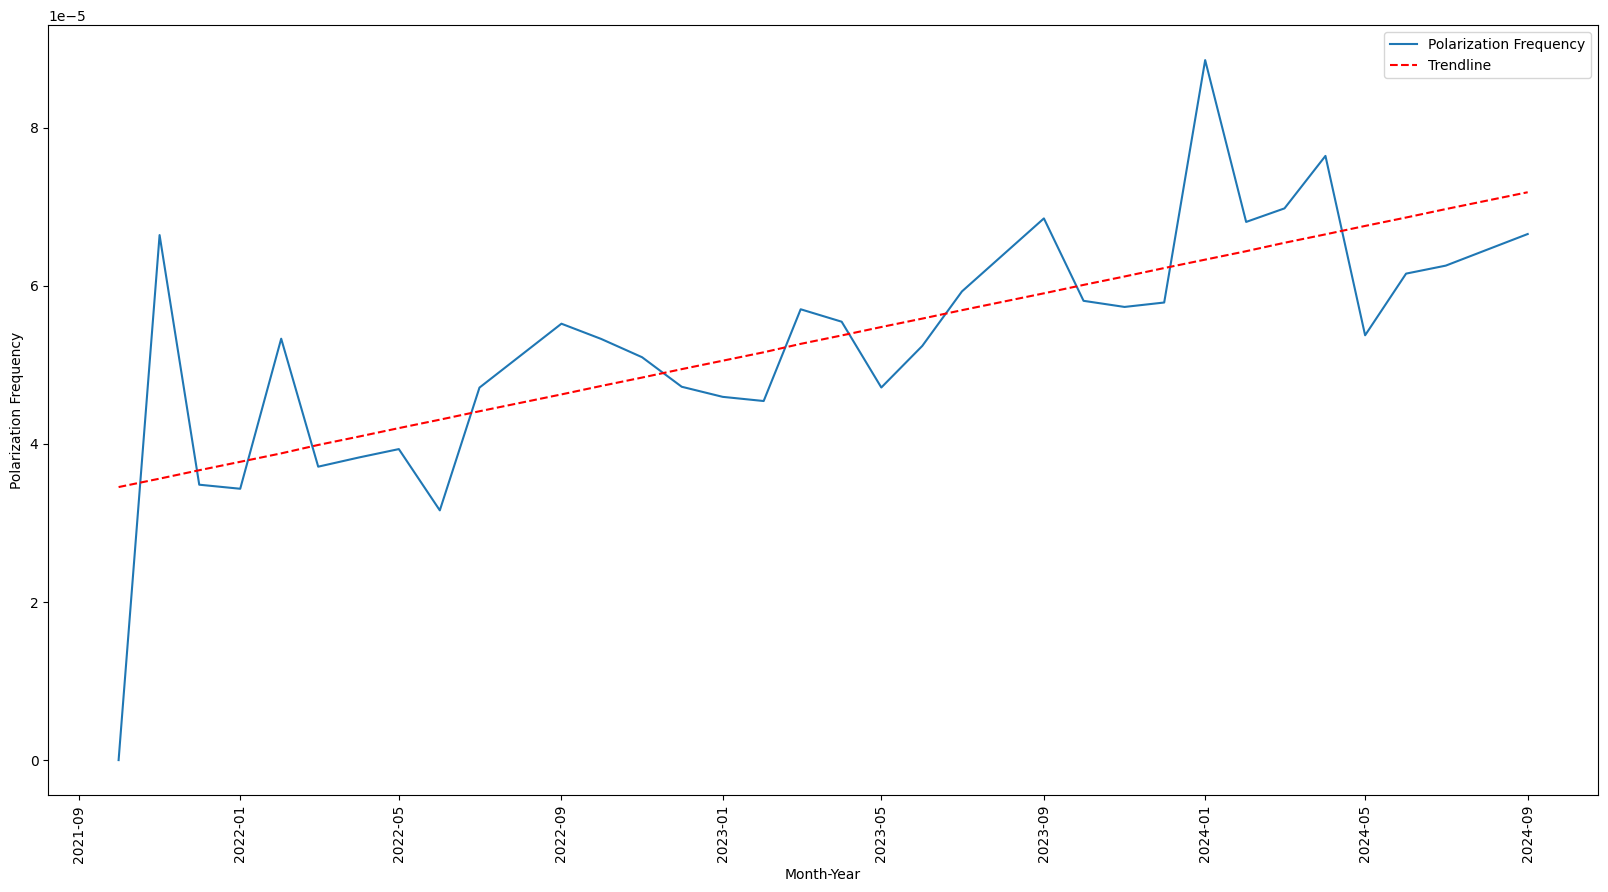

In [135]:
features_with_polarization_20['month_year'] = pd.to_datetime(features_with_polarization_20['date']).dt.to_period('M')

features_with_polarization_20_grouped = features_with_polarization_20.groupby('month_year').agg({'polarizing':'sum', 'speech_length':'sum'}).reset_index()

features_with_polarization_20_grouped['polarizing_frequency'] = features_with_polarization_20_grouped['polarizing']/features_with_polarization_20_grouped['speech_length']

features_with_polarization_20_grouped['month_year'] = features_with_polarization_20_grouped['month_year'].dt.to_timestamp()

features_with_polarization_20_grouped['time_index'] = (features_with_polarization_20_grouped['month_year'].dt.year - features_with_polarization_20_grouped['month_year'].dt.year.min()) * 12 + features_with_polarization_20_grouped['month_year'].dt.month

X = features_with_polarization_20_grouped['time_index'].values.reshape(-1, 1)
y = features_with_polarization_20_grouped['polarizing_frequency'].values

model = LinearRegression()
model.fit(X, y)

trendline = model.predict(X)

plt.figure(figsize=(20,10))
plt.plot(features_with_polarization_20_grouped['month_year'], features_with_polarization_20_grouped['polarizing_frequency'], label='Polarization Frequency')
plt.plot(features_with_polarization_20_grouped['month_year'], trendline, label='Trendline', color='red', linestyle='--')

plt.xlabel('Month-Year')
plt.ylabel('Polarization Frequency')
plt.xticks(rotation=90)
plt.legend()

plt.show()


# 5. Analysis by parties

## 5.1 Analysis by all Parties

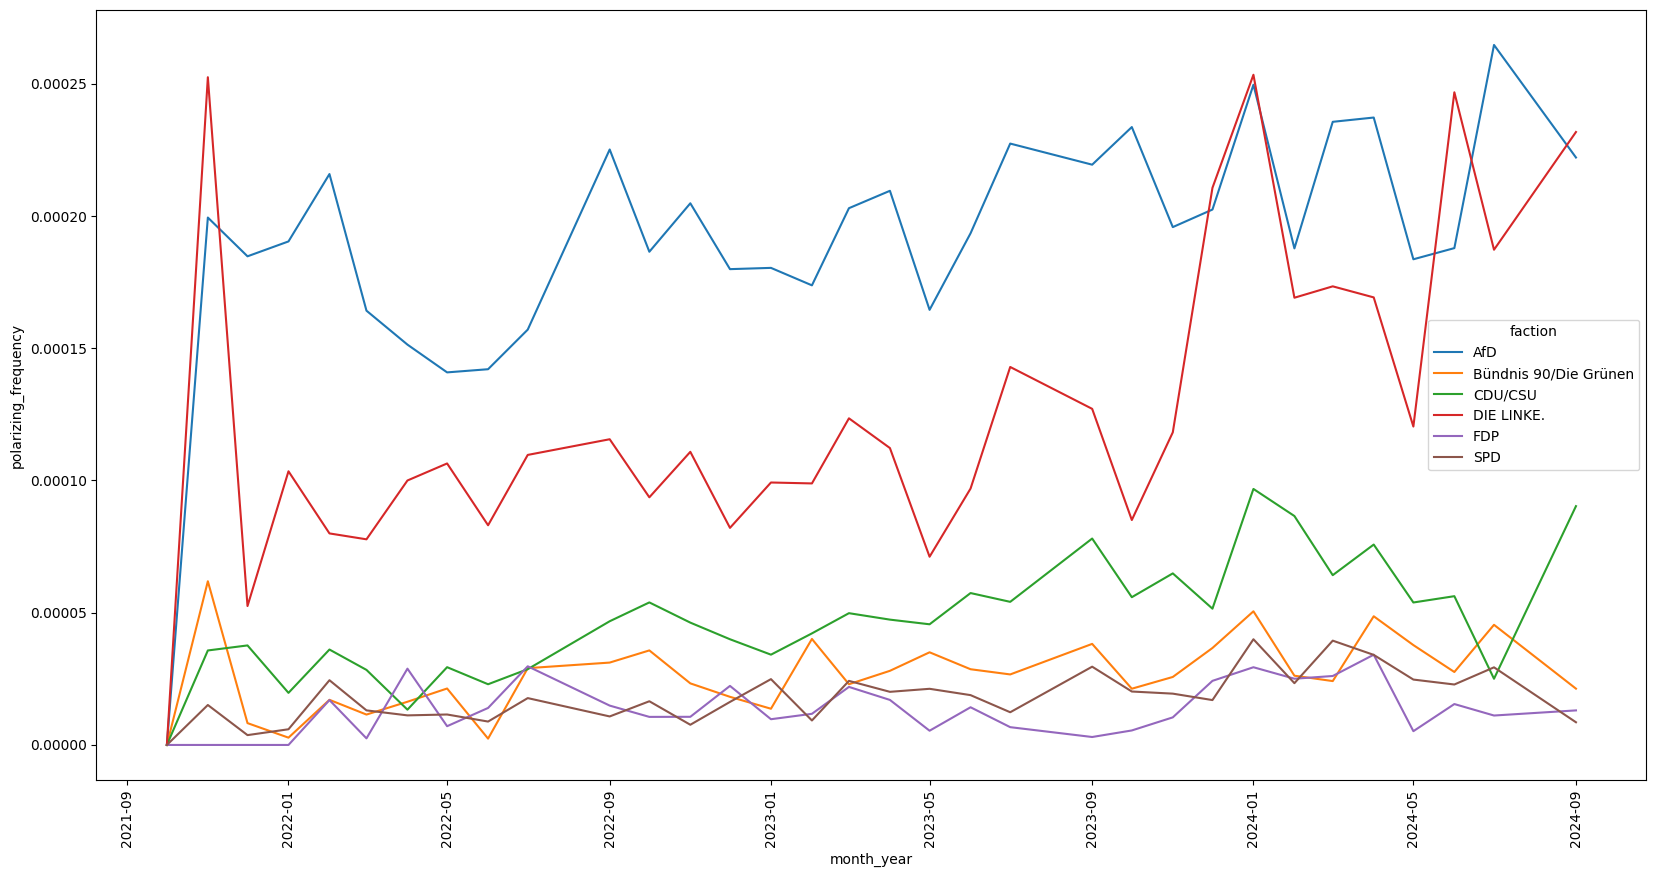

In [119]:
# group by faction, sum polarizinng, vizaulize
features_with_polarization_20_grouped_faction = features_with_polarization_20.groupby(['month_year', 'faction']).agg({'polarizing':'sum', 'speech_length':'sum'}).reset_index()

features_with_polarization_20_grouped_faction = features_with_polarization_20_grouped_faction[features_with_polarization_20_grouped_faction['faction'] != 'Fraktionslos']


features_with_polarization_20_grouped_faction['polarizing_frequency'] = features_with_polarization_20_grouped_faction['polarizing']/features_with_polarization_20_grouped_faction['speech_length']

features_with_polarization_20_grouped_faction['month_year'] = features_with_polarization_20_grouped_faction['month_year'].dt.to_timestamp()

plt.figure(figsize=(20,10))
sns.lineplot(data=features_with_polarization_20_grouped_faction, x='month_year', y='polarizing_frequency', hue='faction')
plt.xticks(rotation=90)
plt.show()


In [111]:
features_with_polarization_20_grouped_faction['moving_avg'] = features_with_polarization_20_grouped_faction.groupby('faction')['polarizing_frequency'].transform(lambda x: x.rolling(window=1, min_periods=1).mean())

average_moving_avg = features_with_polarization_20_grouped_faction.groupby('faction')['moving_avg'].mean().reset_index()

print(average_moving_avg)


                 faction  moving_avg
0                    AfD    0.000191
1  Bündnis 90/Die Grünen    0.000027
2                CDU/CSU    0.000048
3             DIE LINKE.    0.000127
4                    FDP    0.000014
5                    SPD    0.000018


In [126]:
trend_results = []

for faction, group in features_with_polarization_20_grouped_faction.groupby('faction'):
    first_nonzero_month = group[group['polarizing_frequency'] > 0].iloc[0]

    last_month = group['month_year'].max()

    first_value = first_nonzero_month['polarizing_frequency']

    last_value = group[group['month_year'] == last_month]['polarizing_frequency'].mean()

    delta_polarizing_frequency = last_value - first_value

    trend_results.append({
        'faction': faction,
        'first_value': first_value,
        'last_value': last_value,
        'delta_polarizing_frequency': delta_polarizing_frequency
    })

trend_df = pd.DataFrame(trend_results)

trend_df['percentage_change'] = (trend_df['delta_polarizing_frequency'] / trend_df['first_value']) * 100

print("Vergleich der Polarisierungsfrequenz im ersten und letzten Monat:")
print(trend_df)


Vergleich der Polarisierungsfrequenz im ersten und letzten Monat:
                 faction  first_value  last_value  delta_polarizing_frequency  \
0                    AfD     0.000199    0.000222                    0.000023   
1  Bündnis 90/Die Grünen     0.000062    0.000021                   -0.000041   
2                CDU/CSU     0.000036    0.000090                    0.000055   
3             DIE LINKE.     0.000252    0.000232                   -0.000021   
4                    FDP     0.000017    0.000013                   -0.000004   
5                    SPD     0.000015    0.000009                   -0.000007   

   percentage_change  
0          11.385314  
1         -65.605060  
2         152.709075  
3          -8.203491  
4         -23.015093  
5         -43.205893  


In [127]:
features_with_polarization_20_grouped_faction['time_index'] = (
    (features_with_polarization_20_grouped_faction['month_year'].dt.year - features_with_polarization_20_grouped_faction['month_year'].dt.year.min()) * 12
    + features_with_polarization_20_grouped_faction['month_year'].dt.month
)

# Initialisiere ein Dictionary für die Trend-Ergebnisse
trend_results = {}

# Führe die lineare Regression für jede Fraktion durch
for faction, group in features_with_polarization_20_grouped_faction.groupby('faction'):
    X = group['time_index'].values.reshape(-1, 1)  # Zeitindex als unabhängige Variable
    y = group['polarizing_frequency'].values  # Polarisierungsfrequenz als abhängige Variable

    # Erstelle und passe das lineare Regressionsmodell an
    model = LinearRegression()
    model.fit(X, y)

    # Speichere die Steigung (Trend) der Regressionsgerade für jede Fraktion
    trend_results[faction] = model.coef_[0]

# Konvertiere die Ergebnisse in ein DataFrame
trend_df = pd.DataFrame(list(trend_results.items()), columns=['faction', 'trend_4_years'])

# Zeige nur die Trend-Spalte
print("Trend über die letzten 4 Jahre für jede Fraktion:")
print(trend_df)


Trend über die letzten 4 Jahre für jede Fraktion:
                 faction  trend_4_years
0                    AfD   2.464081e-06
1  Bündnis 90/Die Grünen   6.096711e-07
2                CDU/CSU   1.547202e-06
3             DIE LINKE.   3.392353e-06
4                    FDP   3.322459e-07
5                    SPD   5.737170e-07


## 5.2 Analysis Governing vs. Opposition

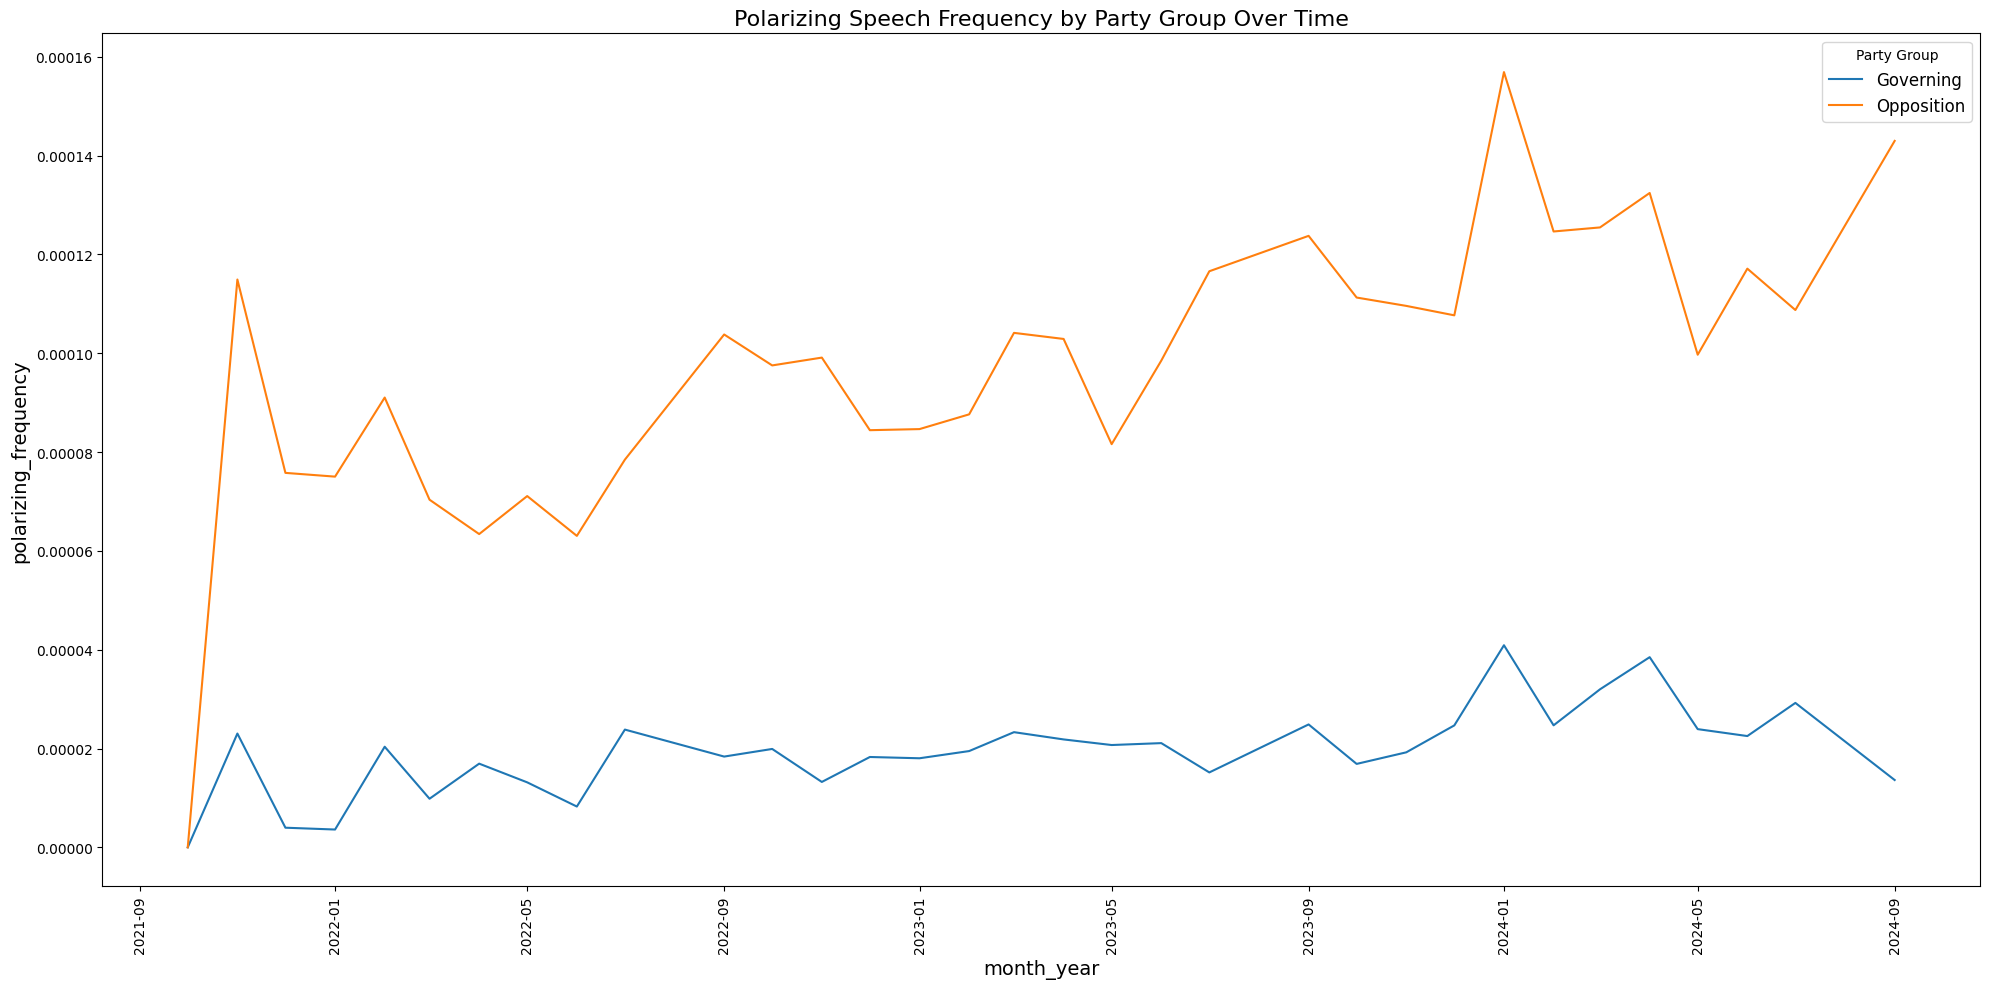

In [136]:
# Definiere die Gruppierung der Fraktionen in 'Governing' und 'Opposition'
governing_parties = ['SPD', 'Bündnis 90/Die Grünen', 'FDP']
opposition_parties = ['AfD', 'DIE LINKE.','CDU/CSU']

features_with_polarization_20_grouped_faction = features_with_polarization_20_grouped_faction[features_with_polarization_20_grouped_faction['faction'] != 'Fraktionslos']

features_with_polarization_20_grouped_faction['party_group'] = features_with_polarization_20_grouped_faction['faction'].apply(
    lambda x: 'Governing' if x in governing_parties else ('Opposition' if x in opposition_parties else 'Other'))

features_with_polarization_20_grouped_faction = features_with_polarization_20_grouped_faction.groupby(['month_year', 'party_group']).agg({'polarizing': 'sum', 'speech_length': 'sum'}).reset_index()

features_with_polarization_20_grouped_faction['polarizing_frequency'] = features_with_polarization_20_grouped_faction['polarizing'] / features_with_polarization_20_grouped_faction['speech_length']

plt.figure(figsize=(20, 10))
sns.lineplot(data=features_with_polarization_20_grouped_faction, x='month_year', y='polarizing_frequency', hue='party_group')
plt.xticks(rotation=90)
plt.title("Polarizing Speech Frequency by Party Group Over Time", fontsize=16)
plt.xlabel("month_year", fontsize=14)
plt.ylabel("polarizing_frequency", fontsize=14)
plt.legend(title='Party Group', fontsize=12)
plt.tight_layout()
plt.show()


# 6. Demographics

## 6.1 By Gender


In [14]:
# group by gender, sum polarizing, vizaulize
features_with_polarization_20_gender = features_with_polarization_20.groupby('gender').agg({'polarizing':'sum', 'speech_length':'sum'}).reset_index()

features_with_polarization_20_gender['polarizing_frequency'] = features_with_polarization_20_gender['polarizing']/features_with_polarization_20_gender['speech_length']

features_with_polarization_20_gender

,gender,polarizing,speech_length,polarizing_frequency
0,männlich,3199.0,51542636,0.000062
1,weiblich,1039.0,24630399,0.000042


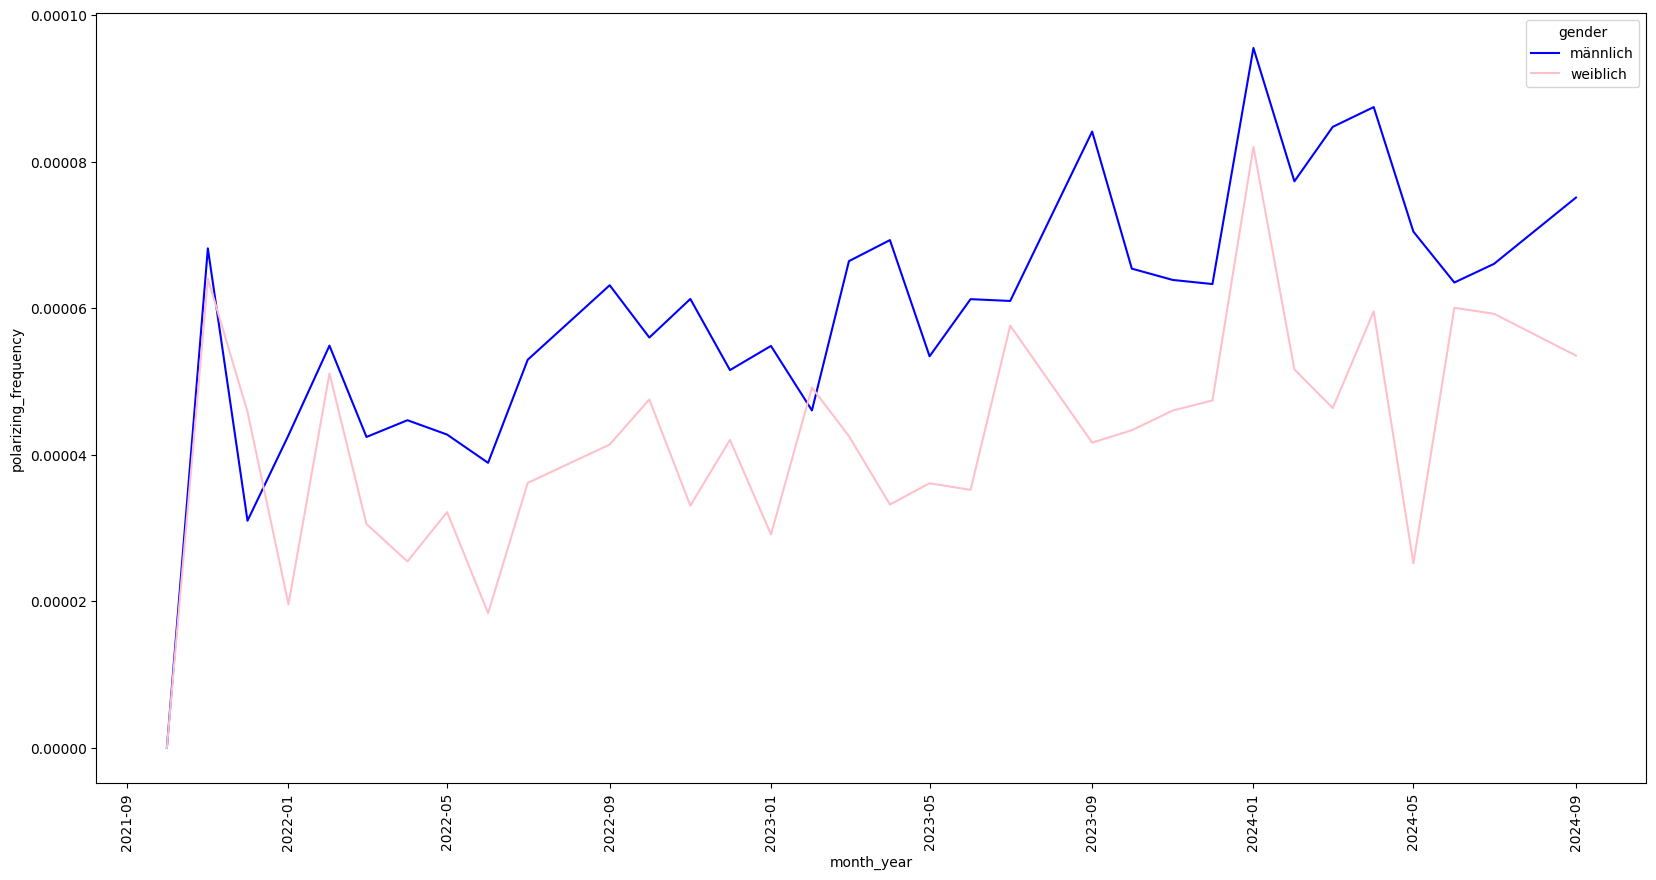

In [49]:
features_with_polarization_20_grouped_gender = features_with_polarization_20.groupby(['month_year', 'gender']).agg({'polarizing':'sum', 'speech_length':'sum'}).reset_index()

features_with_polarization_20_grouped_gender['polarizing_frequency'] = features_with_polarization_20_grouped_gender['polarizing']/features_with_polarization_20_grouped_gender['speech_length']

features_with_polarization_20_grouped_gender['month_year'] = features_with_polarization_20_grouped_gender['month_year'].dt.to_timestamp()

palette = {'männlich': 'blue', 'weiblich': 'pink'}

plt.figure(figsize=(20, 10))
sns.lineplot(data=features_with_polarization_20_grouped_gender, x='month_year', y='polarizing_frequency', hue='gender', palette=palette)
plt.xticks(rotation=90)
plt.show()


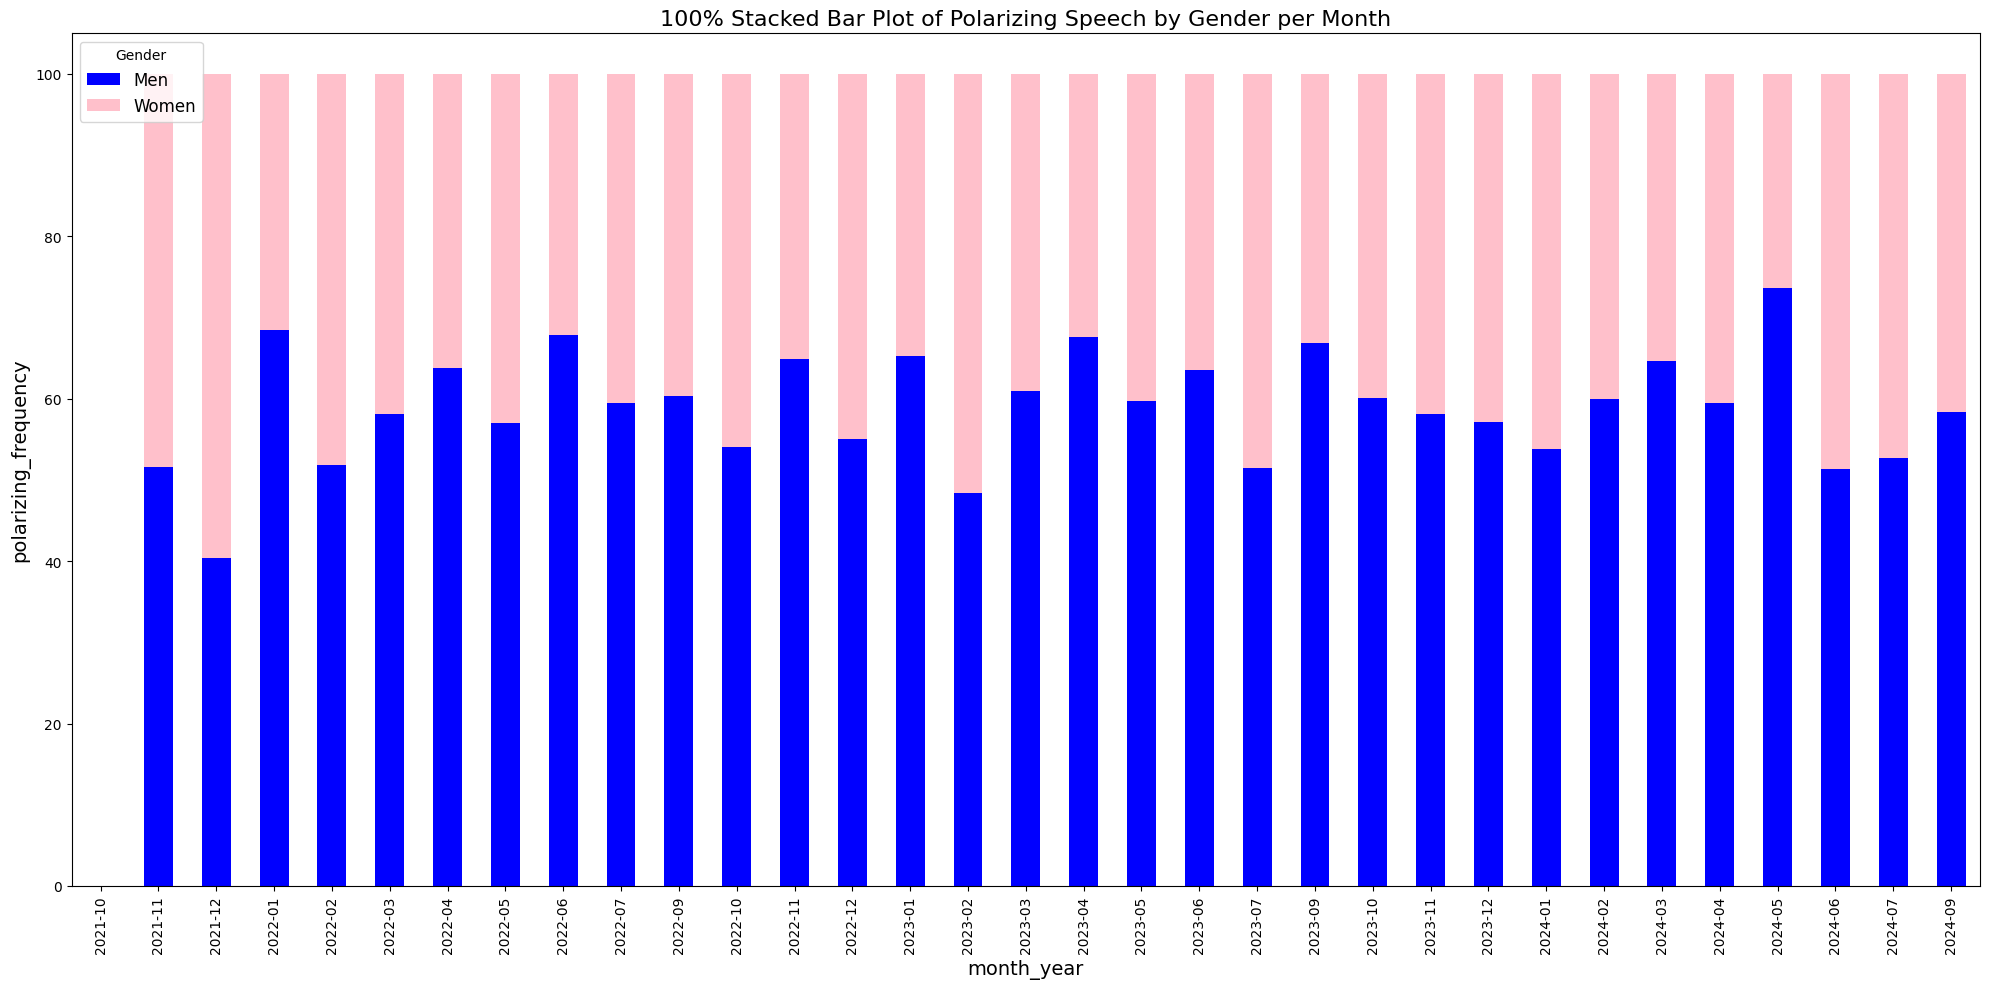

In [137]:
# Berechne die Summe der polarisierenden Reden und die Gesamtzahl der Reden pro Monat
features_with_polarization_20_grouped_gender_stacked = features_with_polarization_20.groupby(['month_year', 'gender']).agg({'polarizing': 'sum', 'speech_length':'sum'}).reset_index()

features_with_polarization_20_grouped_gender_stacked['polarizing_frequency'] = features_with_polarization_20_grouped_gender_stacked['polarizing']/features_with_polarization_20_grouped_gender_stacked['speech_length']

features_pivot = features_with_polarization_20_grouped_gender_stacked.pivot(index='month_year', columns='gender', values='polarizing_frequency').fillna(0)

features_pivot_percent = features_pivot.div(features_pivot.sum(axis=1), axis=0) * 100

colors = ['blue', 'pink']

features_pivot_percent.plot(kind='bar', stacked=True, color=colors, figsize=(20, 10), width= 0.5)

plt.title('100% Stacked Bar Plot of Polarizing Speech by Gender per Month', fontsize=16)
plt.xlabel('month_year', fontsize=14)
plt.ylabel('polarizing_frequency', fontsize=14)

plt.xticks(rotation=90)

plt.legend(title='Gender', labels=['Men', 'Women'], fontsize=12)

plt.tight_layout()
plt.show()


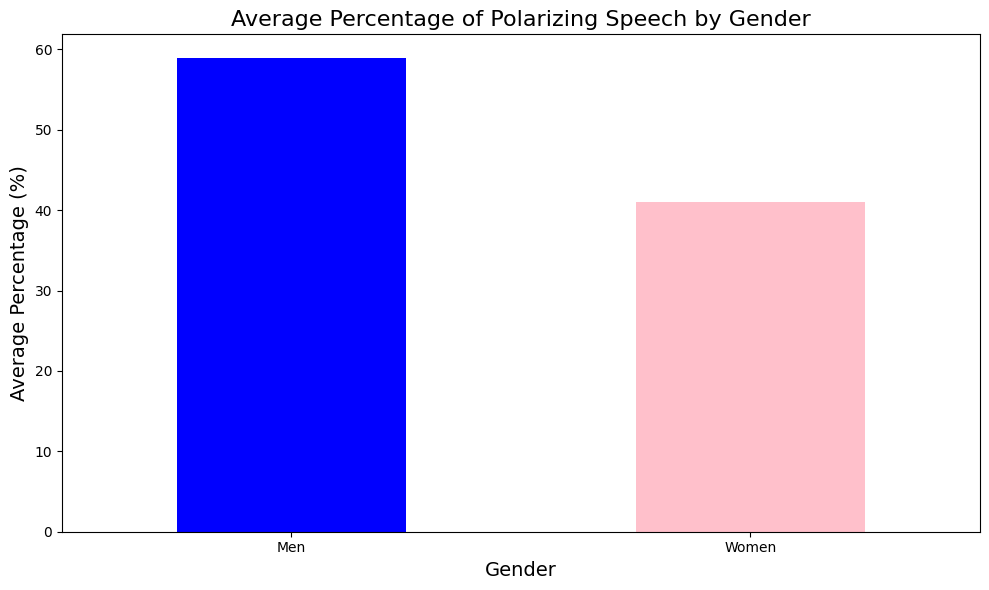

In [17]:
average_polarizing_percent = features_pivot_percent.mean()

plt.figure(figsize=(10, 6))
average_polarizing_percent.plot(kind='bar', color=['blue', 'pink'], width=0.5)

plt.title('Average Percentage of Polarizing Speech by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Average Percentage (%)', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Men', 'Women'], rotation=0)

plt.tight_layout()
plt.show()


## 6.2 By Age

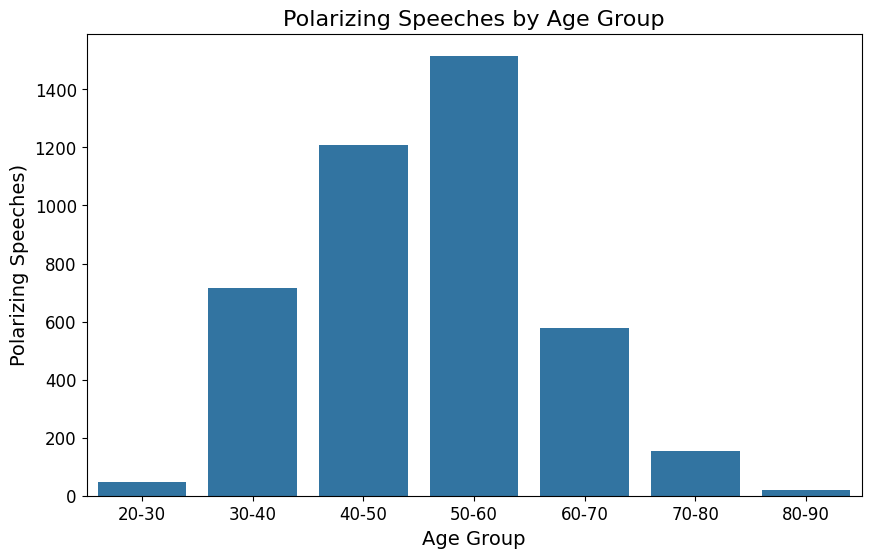

In [18]:
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
features_with_polarization_20['age_group'] = pd.cut(features_with_polarization_20['age'], bins=bins, labels=labels, right=False)

features_with_polarization_20_age = features_with_polarization_20.groupby('age_group').agg({
    'polarizing': 'sum',
    'speech_length': 'sum'
}).reset_index()

#features_with_polarization_20_age['polarizing_frequency'] = (features_with_polarization_20_age['polarizing'] / features_with_polarization_20_age['speech_length'])

features_with_polarization_20_age = features_with_polarization_20_age.sort_values(by='polarizing', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=features_with_polarization_20_age, x='age_group', y='polarizing')
plt.title("Polarizing Speeches by Age Group", fontsize=16)
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Polarizing Speeches", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="", alpha=0.7)
plt.show()


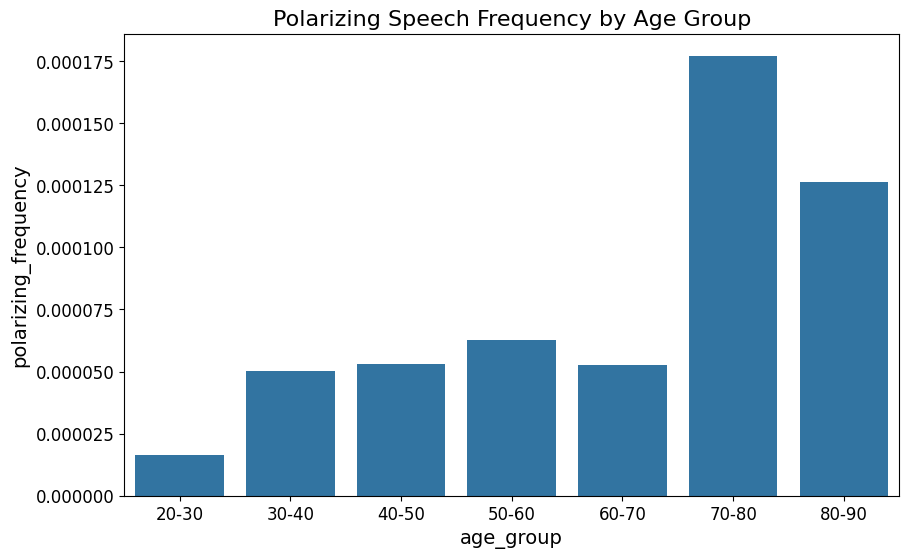

In [138]:
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
features_with_polarization_20['age_group'] = pd.cut(features_with_polarization_20['age'], bins=bins, labels=labels, right=False)

features_with_polarization_20_age = features_with_polarization_20.groupby('age_group').agg({
    'polarizing': 'sum',
    'speech_length': 'sum'
}).reset_index()

features_with_polarization_20_age['polarizing_frequency'] = (features_with_polarization_20_age['polarizing'] / features_with_polarization_20_age['speech_length'])

features_with_polarization_20_age = features_with_polarization_20_age.sort_values(by='polarizing_frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=features_with_polarization_20_age, x='age_group', y='polarizing_frequency')
plt.title("Polarizing Speech Frequency by Age Group", fontsize=16)
plt.xlabel("age_group", fontsize=14)
plt.ylabel("polarizing_frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="", alpha=0.7)
plt.show()


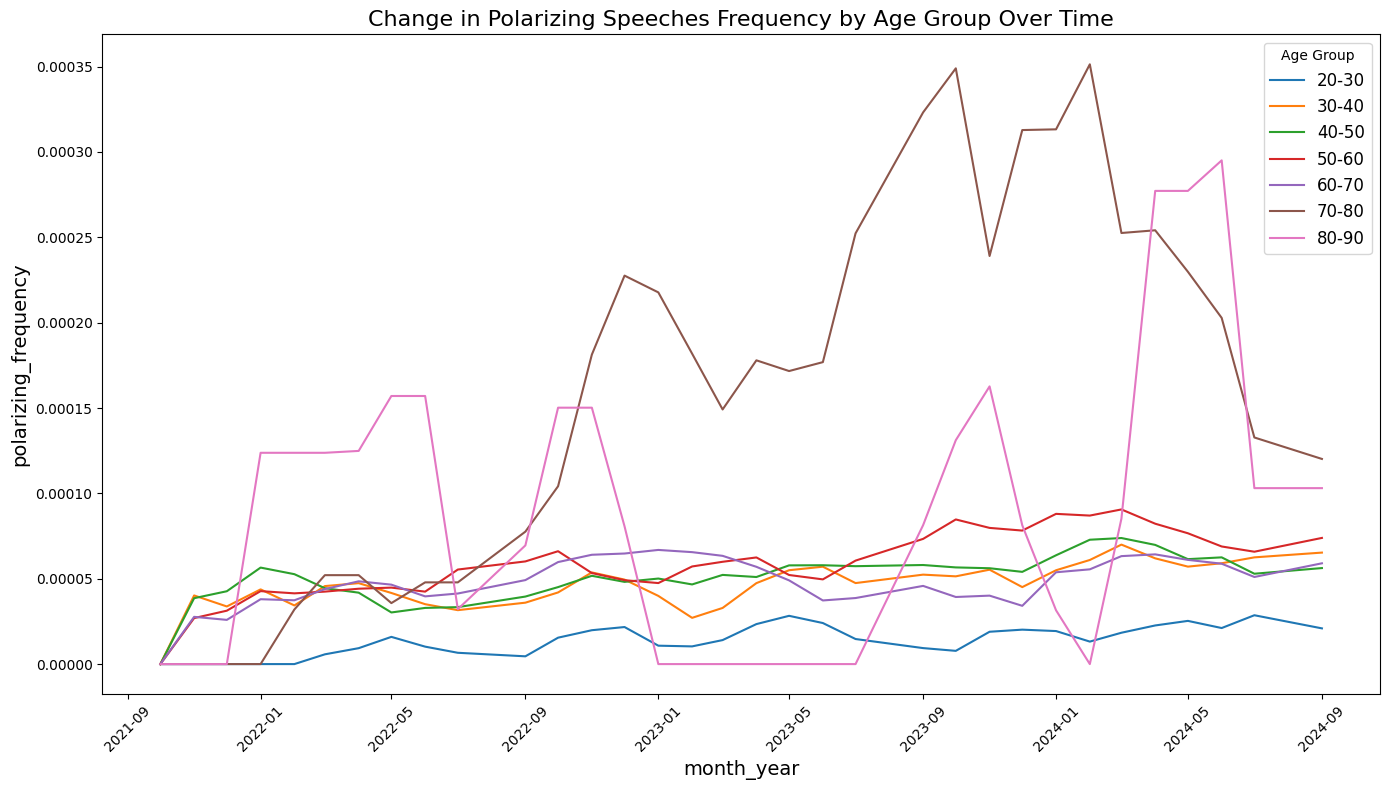

In [140]:
features_with_polarization_20['month_year'] = pd.to_datetime(features_with_polarization_20['date']).dt.to_period('M')
features_with_polarization_20['month_year'] = features_with_polarization_20['month_year'].dt.to_timestamp()

features_with_polarization_20_age_time = features_with_polarization_20.groupby(['month_year', 'age_group']).agg({
    'polarizing': 'sum',
    'speech_length': 'sum'
}).reset_index()

features_with_polarization_20_age_time['speech_length'] = features_with_polarization_20_age_time['speech_length'].fillna(0)

features_with_polarization_20_age_time['polarizing_frequency_age'] = 0

mask = features_with_polarization_20_age_time['speech_length'] > 0
features_with_polarization_20_age_time.loc[mask, 'polarizing_frequency_age'] = (
    features_with_polarization_20_age_time.loc[mask, 'polarizing'] / features_with_polarization_20_age_time.loc[mask, 'speech_length']
)

features_with_polarization_20_age_time['polarizing_frequency_smooth'] = features_with_polarization_20_age_time.groupby('age_group')['polarizing_frequency_age'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

plt.figure(figsize=(14, 8))
sns.lineplot(data=features_with_polarization_20_age_time, x='month_year', y='polarizing_frequency_smooth', hue='age_group', marker='')

plt.title("Change in Polarizing Speeches Frequency by Age Group Over Time", fontsize=16)
plt.xlabel("month_year", fontsize=14)
plt.ylabel("polarizing_frequency", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Age Group', fontsize=12)
plt.tight_layout()

plt.show()


# 7.Impact of Political Experience on Polarization

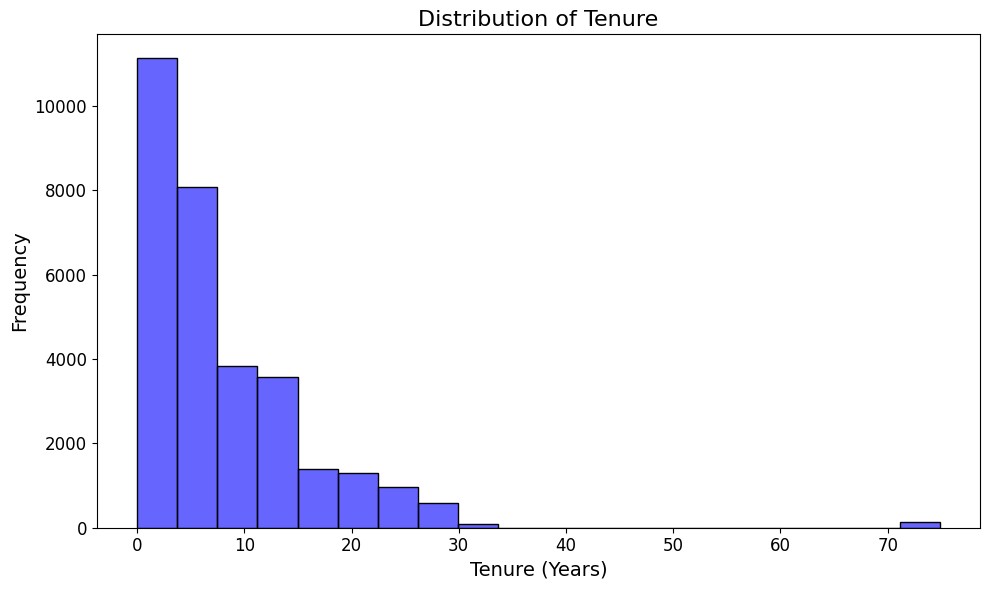

In [97]:
# plot distribution
features_with_polarization_20_tenure = features_with_polarization_20[['tenure', 'polarizing', 'speech_length']]
plt.figure(figsize=(10, 6))

# Histogramm mit KDE
sns.histplot(data=features_with_polarization_20_tenure, x='tenure', bins=20, color='blue', alpha=0.6)

# Titel und Achsenbeschriftungen anpassen
plt.title("Distribution of Tenure", fontsize=16)
plt.xlabel("Tenure (Years)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="", alpha=0.7)

# Plot anzeigen
plt.tight_layout()
plt.show()

In [99]:
# remove outliers

features_with_polarization_20_tenure_cleaned = features_with_polarization_20_tenure[features_with_polarization_20_tenure["tenure"] < 70]

In [129]:
correlation = features_with_polarization_20_tenure_cleaned[['tenure', 'polarizing_frequency']].corr(method='pearson')

print("Pearson correlation between tenure and polarizing_frequency:")
print(correlation)

Pearson correlation between tenure and polarizing_frequency:
                        tenure  polarizing_frequency
tenure                1.000000             -0.005867
polarizing_frequency -0.005867              1.000000


In [101]:
# Berechnung des Pearson-Korrelationskoeffizienten zwischen Tenure und Polarization
correlation = features_with_polarization_20_tenure_cleaned[['tenure', 'polarizing']].corr(method='pearson')

# Ausgabe der Korrelation
print("Pearson correlation between tenure and polarization:")
print(correlation)


Pearson correlation between tenure and polarization:
              tenure  polarizing
tenure      1.000000   -0.042415
polarizing -0.042415    1.000000


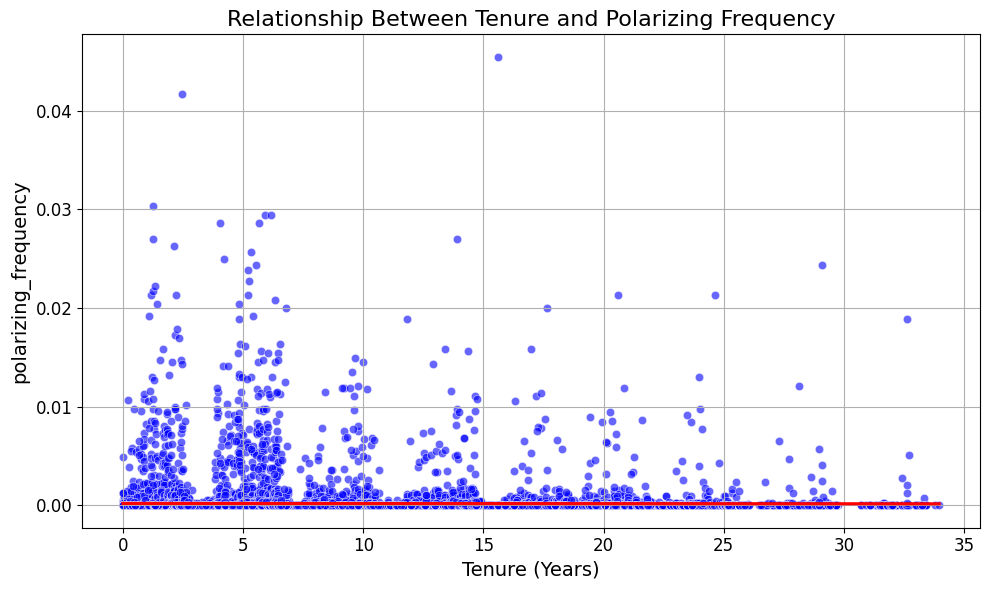

In [141]:
features_with_polarization_20_tenure_cleaned['polarizing_frequency'] = features_with_polarization_20_tenure_cleaned['polarizing'] / features_with_polarization_20_tenure_cleaned['speech_length']

# Erstellen eines Streudiagramms von Tenure vs. Polarizing Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features_with_polarization_20_tenure_cleaned, x='tenure', y='polarizing_frequency', color='blue', alpha=0.6)

# Hinzufügen einer linearen Regression zur Darstellung des Zusammenhangs
sns.regplot(data=features_with_polarization_20_tenure_cleaned, x='tenure', y='polarizing_frequency', scatter=False, color='red')

# Titel und Achsenbeschriftungen anpassen
plt.title("Relationship Between Tenure and Polarizing Frequency", fontsize=16)
plt.xlabel("Tenure (Years)", fontsize=14)
plt.ylabel("polarizing_frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot anzeigen
plt.tight_layout()
plt.show()


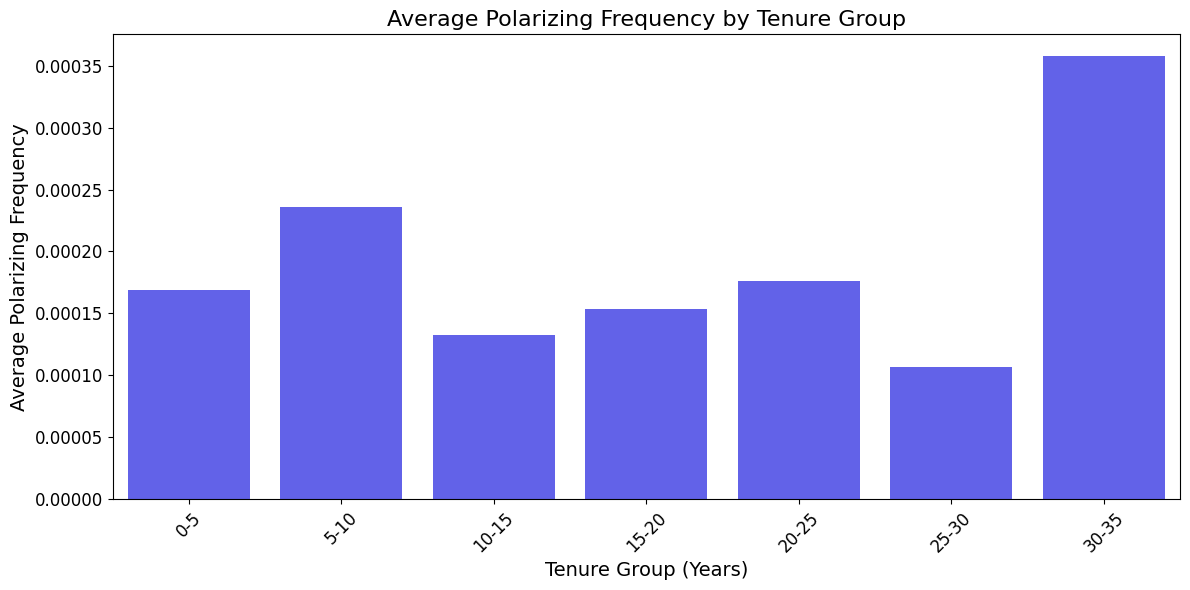

In [106]:
bins = range(0, int(features_with_polarization_20_tenure_cleaned['tenure'].max()) + 5, 5)
labels = [f"{i}-{i+5}" for i in bins[:-1]]
features_with_polarization_20_tenure_cleaned['tenure_group'] = pd.cut(features_with_polarization_20_tenure_cleaned['tenure'], bins=bins, labels=labels, right=False)

avg_polarization_per_group = features_with_polarization_20_tenure_cleaned.groupby('tenure_group')['polarizing_frequency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_polarization_per_group, x='tenure_group', y='polarizing_frequency', color='blue', alpha=0.7)

plt.title("Average Polarizing Frequency by Tenure Group", fontsize=16)
plt.xlabel("Tenure Group (Years)", fontsize=14)
plt.ylabel("Average Polarizing Frequency", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="", alpha=0.7)

plt.tight_layout()
plt.show()


# 8. Polarizing Topics